In [1]:
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import platform
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from event_utils import get_events
from create_stim_table import create_stim_df
import matplotlib.pyplot as plt
%matplotlib inline

# This patch of code just ensures we get an easy to read font size for the duration of the notebook
import matplotlib
font = {'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

In [2]:
# Set file location based on platform. 
platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"

In [3]:
def find_divide_indices(stim_table):
    '''
    Finds the indices where each new stimulus presentation after the first presentation
    starts.
    
    Returns:
        List of indices representing the start of the next stimulus
    '''
    # Find the indices where each new stimulus presentation after the first presentation starts
    divide_indices = []

    for i in range(min(stim_table.index), max(stim_table.index)):
        try:
            if stim_table.start[i+1]-stim_table.end[i] > 100:
                divide_indices.append(i) # saves index where new stim presentation begins
        except:
            pass
    return divide_indices

In [4]:
def divide_stim_table(stim_table, divide_indices=[]):
    '''
    Divides input stimulus table based on indices corresponding to separate stimulus
    presentations.
    If there were 3 presentations, three dataframes for each presentation are returned. 
    If there were 2 presentations, three dataframes for each presentation are still 
    returned with the third being null.
    
    Returns:
        3 divided stimulus tables corresponding to first, second, and third or null stimulus
        presentation start. 
    '''
    if len(divide_indices)==2: # 3 presentations 
        return stim_table.loc[:divide_indices[0]], stim_table.loc[divide_indices[0]+1:divide_indices[1]], stim_table.loc[divide_indices[1]+1:]
    elif len(divide_indices) == 1: # 2 presentations
        return stim_table.loc[:divide_indices[0]], stim_table.loc[divide_indices[0]+1:], pd.DataFrame()
    else:
        raise Exception("Stimulis has only one presentation. Nothing to divide.")

In [14]:
def generate_response_matrices(stim_table, all_events):
    '''
    This function generates response matrices given an input stimulus table. 
    Stimulus table can be divided based on stimulus presentations, or undivided.
    
    Returns:
        orientation_matrix: 1D array with orientation value for each frame
        frequency_matrix: 1D array with frequency value for each frame
        response: matrix of shape (# cells, # stimuli, 60) with response of each
            cell to each stimulus over its presentation period of 60 frames 
    '''
    stim_table = stim_table.reset_index(drop=True)
    if stim_table.stim_category[0] == "drifting_gratings": # need to split stim ID
        # generate response matrix
        response = np.empty((len(all_events.index), len(stim_table), 60)) # 3d array for responses at each frame to each stimulus for each neuron
        for i in range(len(stim_table)):
            for cell_index in range(len(all_events.index)):
                response[cell_index,i,:] = all_events.iloc[cell_index, stim_table.start[i]:stim_table.start[i]+60]
        return response
    elif stim_table.stim_category[0] == "static_gratings" or stim_table.stim_category[0] == "natural_scenes":
        # generate response matrix
        response = np.empty((len(all_events.index), len(stim_table), 7)) # 3d array for responses at each frame to each stimulus for each neuron
        stim_table = stim_table.reset_index(drop=True)
        for i in range(len(stim_table)):
            for cell_index in range(len(all_events.index)):
                response[cell_index,i,:] = all_events.iloc[cell_index, stim_table.start[i]:stim_table.start[i]+7]
        return response
    
    
# OLD: natural scenes stimulus matrix
#         stimulus_matrix = np.zeros(len(stim_table))
#         null = np.zeros(1)
#         # Loop through each stimulus presentation, store its parameters
#         for i in range(len(stim_table)):
#             # extract orientation and temporal frequency info by splitting stimulus ID
#             stimulus_matrix[i] = stim_table.stim_id[i]

In [6]:
def responses_per_stimulus(stim_table, response_matrix):
    '''
    response_matrix: contains all recorded responses in the divided time frame 
    '''
    responses_by_stimulus = pd.DataFrame(columns=["stim_id","response_matrix"])
    
    for stim_id in np.unique(stim_table.stim_id):
        stim_table_reset = stim_table.reset_index(drop=True) # reset full stim table indices 
        temp_stim_id_df = stim_table_reset[stim_table_reset.stim_id==stim_id] # to index specific stimuli
        response_stimulus_matrix = response_matrix[:,list(temp_stim_id_df.index),:]
        responses_by_stimulus.loc[len(responses_by_stimulus)] = [stim_id, response_stimulus_matrix]
    
    return responses_by_stimulus

In [7]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = os.path.join(data_root,'allen-brain-observatory/visual-coding-2p/manifest.json')

# Create data cache object 
boc = BrainObservatoryCache(manifest_file=manifest_file)

In [8]:
# Select the relevant data for chosen container ID
desired_container_id = 688678764
desired_container = boc.get_ophys_experiments(experiment_container_ids=[desired_container_id])
desired_container = sorted(desired_container, key=lambda x: x['session_type']) # sort based on session type so A comes first

# Get session IDs for each session
session_one_id = desired_container[0]["id"]

# load in session data for each session
session_one = boc.get_ophys_experiment_data(ophys_experiment_id=session_one_id)

# Get all event traces for all neurons in given session 
all_events = get_events(boc, session_one_id, "VISp")

# Get full stimulus table for a given session
stim_table = create_stim_df(boc, session_one_id)

In [9]:
# Drifting gratings, session 1

In [10]:
drifting_gratings_table = stim_table[stim_table.stim_category == "drifting_gratings"]

In [11]:
divide_indices = find_divide_indices(drifting_gratings_table)

In [55]:
dg1, dg2, dg3 = divide_stim_table(drifting_gratings_table, divide_indices)

In [15]:
response1 = generate_response_matrices(dg1, all_events)
response2 = generate_response_matrices(dg2, all_events)
response3 = generate_response_matrices(dg3, all_events)

In [16]:
# Responses for each presentation for each stimulus

In [17]:
# Create dataframe with response matrix for each stimulus ID
dg1_responses_by_stimulus = responses_per_stimulus(dg1, response1)
dg2_responses_by_stimulus = responses_per_stimulus(dg2, response2)
dg3_responses_by_stimulus = responses_per_stimulus(dg3, response3)

# # The below only works because the shape of the first dataframe is equal to or larger than the others
# responses_by_stimulus = dg1_responses_by_stimulus.copy()
# responses_by_stimulus["response_matrix2"] = dg2_responses_by_stimulus.response_matrix
# responses_by_stimulus["response_matrix3"] = dg3_responses_by_stimulus.response_matrix

In [133]:
test_stimulus1 = dg1_responses_by_stimulus[dg1_responses_by_stimulus.stim_id == "0.0_1.0_0.0"].response_matrix[0]
test_stimulus2 = dg2_responses_by_stimulus[dg2_responses_by_stimulus.stim_id == "0.0_1.0_0.0"].response_matrix[0]
test_stimulus3 = dg3_responses_by_stimulus[dg3_responses_by_stimulus.stim_id == "0.0_1.0_0.0"].response_matrix[0]

# concatenate response matrices for all three sessions to get a response matrix
# for all 15 presentations in the entire session
test_stimulus = np.concatenate((test_stimulus1, test_stimulus2, test_stimulus3), axis=1)
# Sum responses across 60 frames for each 15 stimuli to get one value for each stimulus
summed_responses_test = np.sum(test_stimulus,axis=2).T

pca = PCA(n_components=2) # create PCA model
pca.fit_transform(summed_responses_test) # fit the model with the dataset
summed_responses_test.shape

(15, 475)

In [154]:
# Try sum across 60 frames

# concatenate response matrices for all three sessions to get a response matrix
# for all 15 presentations in the entire session
test_stimulus1 = dg1_responses_by_stimulus[dg1_responses_by_stimulus.stim_id == "0.0_1.0_0.0"].response_matrix[0]
test_stimulus2 = dg2_responses_by_stimulus[dg2_responses_by_stimulus.stim_id == "0.0_1.0_0.0"].response_matrix[0]
test_stimulus3 = dg3_responses_by_stimulus[dg3_responses_by_stimulus.stim_id == "0.0_1.0_0.0"].response_matrix[0]
test_stimulus = np.concatenate((test_stimulus1, test_stimulus2, test_stimulus3), axis=1)
# Sum responses across 60 frames for each 15 stimuli to get one value for each stimulus
summed_responses_test = np.sum(test_stimulus,axis=2).T

pca = PCA(n_components=2) # create PCA model
pca.fit_transform(summed_responses_test) # fit the model with the dataset
summed_responses_test.shape

# Session 1
test = dg1_responses_by_stimulus[dg1_responses_by_stimulus.stim_id == "0.0_1.0_0.0"].response_matrix[0]
summed_responses_test1 = np.sum(test,axis=2).T
test_transformed_data1 = pca.transform(summed_responses_test1) # fit the model with the dataset

# Session 2
test = dg2_responses_by_stimulus[dg2_responses_by_stimulus.stim_id == "0.0_1.0_0.0"].response_matrix[0]
summed_responses_test2 = np.sum(test, axis=2).T
test_transformed_data2 = pca.transform(summed_responses_test2) # fit the model with the dataset

# Session 3
test = dg3_responses_by_stimulus[dg3_responses_by_stimulus.stim_id == "0.0_1.0_0.0"].response_matrix[0]
summed_responses_test3 = np.sum(test, axis=2).T
test_transformed_data3 = pca.transform(summed_responses_test3) # fit the model with the dataset

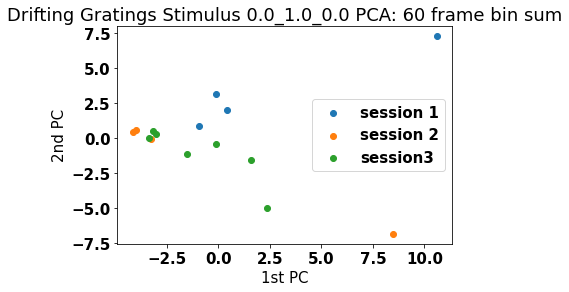

In [155]:
plt.scatter(test_transformed_data1[:,0], test_transformed_data1[:,1], label = "session 1")
plt.scatter(test_transformed_data2[:,0], test_transformed_data2[:,1], label = "session 2")
plt.scatter(test_transformed_data3[:,0], test_transformed_data3[:,1], label = "session 3")
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.title("Drifting Gratings Stimulus 0.0_1.0_0.0 PCA: 30 frame bin sum")
plt.legend(loc="right")
plt.show()

In [165]:
test_stimulus1 = dg1_responses_by_stimulus[dg1_responses_by_stimulus.stim_id == "0.0_1.0_0.0"].response_matrix[0]
test_stimulus2 = dg2_responses_by_stimulus[dg2_responses_by_stimulus.stim_id == "0.0_1.0_0.0"].response_matrix[0]
test_stimulus3 = dg3_responses_by_stimulus[dg3_responses_by_stimulus.stim_id == "0.0_1.0_0.0"].response_matrix[0]

test_stimulus = np.concatenate((test_stimulus1, test_stimulus2, test_stimulus3), axis=1)
test_stimulus_reshaped = np.reshape(test_stimulus, (test_stimulus.shape[0],int(test_stimulus.shape[1]*2), int(test_stimulus.shape[2]/2)))
summed_responses_test = np.sum(test_stimulus_reshaped,axis=2).T

pca = PCA(n_components=2) # create PCA model
pca.fit_transform(summed_responses_test) # fit the model with the dataset
summed_responses_test.shape

(30, 475)

In [161]:
test_stimulus_reshaped = np.reshape(test_stimulus, (test_stimulus.shape[0],int(test_stimulus.shape[1]*2), int(test_stimulus.shape[2]/2)))
test_stimulus.shape

(475, 30, 30)


(475, 15, 60)

In [166]:
# Try sum across 30 frames

# concatenate response matrices for all three sessions to get a response matrix
# for all 15 presentations in the entire session
test_stimulus1 = dg1_responses_by_stimulus[dg1_responses_by_stimulus.stim_id == "0.0_1.0_0.0"].response_matrix[0]
test_stimulus2 = dg2_responses_by_stimulus[dg2_responses_by_stimulus.stim_id == "0.0_1.0_0.0"].response_matrix[0]
test_stimulus3 = dg3_responses_by_stimulus[dg3_responses_by_stimulus.stim_id == "0.0_1.0_0.0"].response_matrix[0]
test_stimulus = np.concatenate((test_stimulus1, test_stimulus2, test_stimulus3), axis=1)

# Reshape matrix to sum over 30 frame bins
test_stimulus_reshaped = np.reshape(test_stimulus, (test_stimulus.shape[0],int(test_stimulus.shape[1]*2), int(test_stimulus.shape[2]/2)))
summed_responses_test = np.sum(test_stimulus_reshaped,axis=2).T

pca = PCA(n_components=2) # create PCA model
pca.fit_transform(summed_responses_test) # fit the model with the dataset
summed_responses_test.shape

# Session 1
test = dg1_responses_by_stimulus[dg1_responses_by_stimulus.stim_id == "0.0_1.0_0.0"].response_matrix[0]
reshape_test = np.reshape(test, (test.shape[0],int(test.shape[1]*2), int(test.shape[2]/2)))
summed_responses_test1 = np.sum(reshape_test, axis=2).T
test_transformed_data1 = pca.transform(summed_responses_test1) # fit the model with the dataset

# Session 2
test = dg2_responses_by_stimulus[dg2_responses_by_stimulus.stim_id == "0.0_1.0_0.0"].response_matrix[0]
reshape_test = np.reshape(test, (test.shape[0],int(test.shape[1]*2), int(test.shape[2]/2)))
summed_responses_test2 = np.sum(reshape_test, axis=2).T
test_transformed_data2 = pca.transform(summed_responses_test2) # fit the model with the dataset

# Session 3
test = dg3_responses_by_stimulus[dg3_responses_by_stimulus.stim_id == "0.0_1.0_0.0"].response_matrix[0]
reshape_test = np.reshape(test, (test.shape[0],int(test.shape[1]*2), int(test.shape[2]/2)))
summed_responses_test3 = np.sum(reshape_test, axis=2).T
test_transformed_data3 = pca.transform(summed_responses_test3) # fit the model with the dataset

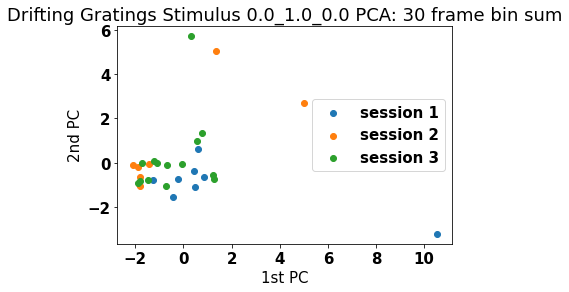

In [167]:
plt.scatter(test_transformed_data1[:,0], test_transformed_data1[:,1], label = "session 1")
plt.scatter(test_transformed_data2[:,0], test_transformed_data2[:,1], label = "session 2")
plt.scatter(test_transformed_data3[:,0], test_transformed_data3[:,1], label = "session 3")
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.title("Drifting Gratings Stimulus 0.0_1.0_0.0 PCA: 30 frame bin sum")
plt.legend(loc="right")
plt.show()

In [ ]:
# Try a cell where mean responses decline

In [271]:
# concatenate response matrices for all three sessions to get a response matrix
# for all 15 presentations in the entire session
stimulus_responses1 = dg1_responses_by_stimulus[dg1_responses_by_stimulus.stim_id == "0.0_2.0_0.0"].response_matrix[2]
stimulus_responses2 = dg2_responses_by_stimulus[dg2_responses_by_stimulus.stim_id == "0.0_2.0_0.0"].response_matrix[2]
stimulus_responses3 = dg3_responses_by_stimulus[dg3_responses_by_stimulus.stim_id == "0.0_2.0_0.0"].response_matrix[2]
all_stimulus_responses = np.concatenate((stimulus_responses1, stimulus_responses2, stimulus_responses3), axis=1)

# Reshape matrix to show each neuron's response to each frame of the 15 stim presentations
all_stimulus_responses_reshaped = np.reshape(all_stimulus_responses, (all_stimulus_responses.shape[0],int(all_stimulus_responses.shape[1] * all_stimulus_responses.shape[2]))).T

pca = PCA(n_components=2) # create PCA model
pca.fit_transform(all_stimulus_responses_reshaped) # fit the model with the dataset

# Session 1
responses_session1 = dg1_responses_by_stimulus[dg1_responses_by_stimulus.stim_id == "0.0_2.0_0.0"].response_matrix[2]
reshape_responses1 = np.reshape(responses_session1, (responses_session1.shape[0],int(responses_session1.shape[1]*responses_session1.shape[2]))).T
transformed_responses1 = pca.transform(reshape_responses1) # fit the model with the dataset

# Session 2
responses_session2 = dg2_responses_by_stimulus[dg2_responses_by_stimulus.stim_id == "0.0_2.0_0.0"].response_matrix[2]
reshape_responses2 = np.reshape(responses_session2, (responses_session2.shape[0],int(responses_session2.shape[1]*responses_session2.shape[2]))).T
transformed_responses2 = pca.transform(reshape_responses2) # fit the model with the dataset

# Session 3
responses_session3 = dg3_responses_by_stimulus[dg3_responses_by_stimulus.stim_id == "0.0_2.0_0.0"].response_matrix[2]
reshape_responses3 = np.reshape(responses_session3, (responses_session3.shape[0],int(responses_session3.shape[1]*responses_session3.shape[2]))).T
transformed_responses2 = pca.transform(reshape_responses3) # fit the model with the dataset


In [274]:
all_stimulus_responses_reshaped.shape

(900, 475)

In [278]:
index=np.arange(transformed_responses1.shape[0])
index.shape

(180,)

In [279]:
transformed_responses1[:,0].shape

(180,)

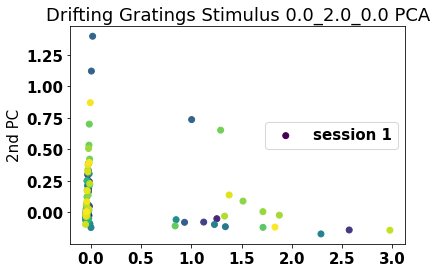

In [281]:
plt.scatter(transformed_responses1[:,0], transformed_responses1[:,1], c=index, cmap='viridis', label = "session 1")
# plt.scatter(transformed_responses2[:,0], transformed_responses2[:,1], label = "session 2")
# plt.scatter(transformed_responses3[:,0], transformed_responses3[:,1], label = "session 3")
# plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.title("Drifting Gratings Stimulus 0.0_2.0_0.0 PCA")
plt.legend(loc="right")
plt.show()

In [288]:
# Try same but bin across 15 frame bins 

# concatenate response matrices for all three sessions to get a response matrix
# for all 15 presentations in the entire session
test_stimulus1 = dg1_responses_by_stimulus[dg1_responses_by_stimulus.stim_id == "0.0_2.0_0.0"].response_matrix[2]
test_stimulus2 = dg2_responses_by_stimulus[dg2_responses_by_stimulus.stim_id == "0.0_2.0_0.0"].response_matrix[2]
test_stimulus3 = dg3_responses_by_stimulus[dg3_responses_by_stimulus.stim_id == "0.0_2.0_0.0"].response_matrix[2]
test_stimulus = np.concatenate((test_stimulus1, test_stimulus2, test_stimulus3), axis=1)

# Reshape matrix to show each neuron's response to each frame of the 15 stim presentations
test_stimulus_reshaped = np.reshape(test_stimulus, (test_stimulus.shape[0],int(test_stimulus.shape[1] * test_stimulus.shape[2]))).T

pca = PCA(n_components=2) # create PCA model
pca.fit_transform(test_stimulus_reshaped) # fit the model with the dataset

# Session 1
test1 = dg1_responses_by_stimulus[dg1_responses_by_stimulus.stim_id == "0.0_2.0_0.0"].response_matrix[2]
reshape_test1 = np.reshape(test1, (test1.shape[0],int(test1.shape[1]*4), int(test1.shape[2]/4)))
summed_responses1 = np.sum(reshape_test1,axis=2).T
test_transformed_data1 = pca.transform(summed_responses1) # fit the model with the dataset

# Session 2
test2 = dg2_responses_by_stimulus[dg2_responses_by_stimulus.stim_id == "0.0_2.0_0.0"].response_matrix[2]
reshape_test2 = np.reshape(test2, (test2.shape[0],int(test2.shape[1]*4), int(test2.shape[2]/4)))
summed_responses2 = np.sum(reshape_test2,axis=2).T
test_transformed_data2 = pca.transform(summed_responses2) # fit the model with the dataset

# Session 3
test3 = dg3_responses_by_stimulus[dg3_responses_by_stimulus.stim_id == "0.0_2.0_0.0"].response_matrix[2]
reshape_test3 = np.reshape(test3, (test3.shape[0],int(test3.shape[1]*4), int(test3.shape[2]/4)))
summed_responses3 = np.sum(reshape_test3,axis=2).T
test_transformed_data3 = pca.transform(summed_responses3) # fit the model with the dataset

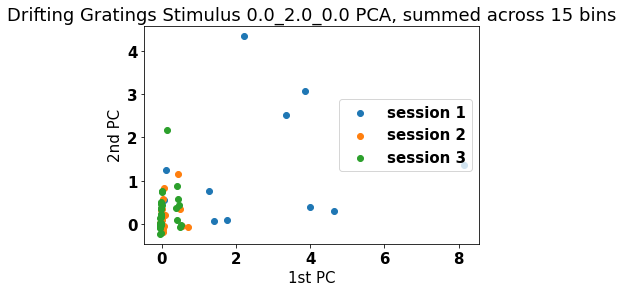

In [289]:
index=np.arange(test_transformed_data1.shape[0])
plt.scatter(test_transformed_data1[:,0], test_transformed_data1[:,1], label = "session 1")
plt.scatter(test_transformed_data2[:,0], test_transformed_data2[:,1], label = "session 2")
plt.scatter(test_transformed_data3[:,0], test_transformed_data3[:,1], label = "session 3")
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.title("Drifting Gratings Stimulus 0.0_2.0_0.0 PCA, summed across 15 bins")
plt.legend(loc="right")
plt.show()

In [248]:
test1.shape

(475, 3, 60)

In [ ]:
# Next try to average each cell's response to each stimulus (40 stimuli, 475 neurons) across three sessions

In [262]:
matrices_list1 = []
for i in range(len(dg1_responses_by_stimulus.stim_id)):
    reshape_dims = (dg1_responses_by_stimulus.response_matrix[i].shape[0], dg1_responses_by_stimulus.response_matrix[i].shape[1]*dg1_responses_by_stimulus.response_matrix[i].shape[2])
    reshaped = np.reshape(dg1_responses_by_stimulus.response_matrix[i], reshape_dims)
    mean_matrix = np.mean(reshaped, axis=1)
    matrices_list1.append(mean_matrix)
matrices_list1 = np.asarray(matrices_list1)

In [263]:
matrices_list2 = []
for i in range(len(dg2_responses_by_stimulus.stim_id)):
    reshape_dims = (dg2_responses_by_stimulus.response_matrix[i].shape[0], dg2_responses_by_stimulus.response_matrix[i].shape[1]*dg2_responses_by_stimulus.response_matrix[i].shape[2])
    reshaped = np.reshape(dg2_responses_by_stimulus.response_matrix[i], reshape_dims)
    mean_matrix = np.mean(reshaped, axis=1)
    matrices_list2.append(mean_matrix)
matrices_list2 = np.asarray(matrices_list2)

In [264]:
matrices_list3 = []
for i in range(len(dg3_responses_by_stimulus.stim_id)):
    reshape_dims = (dg3_responses_by_stimulus.response_matrix[i].shape[0], dg3_responses_by_stimulus.response_matrix[i].shape[1]*dg3_responses_by_stimulus.response_matrix[i].shape[2])
    reshaped = np.reshape(dg3_responses_by_stimulus.response_matrix[i], reshape_dims)
    mean_matrix = np.mean(reshaped, axis=1)
    matrices_list3.append(mean_matrix)
matrices_list3 = np.asarray(matrices_list3)

In [265]:
concat_mean_matrices = np.concatenate((matrices_list1, matrices_list2, matrices_list3), axis=0)
# represents mean response of each cell to each stimulus 

In [266]:
concat_mean_matrices.shape

(122, 475)

In [267]:
import warnings
warnings.filterwarnings('ignore')

pca = PCA(n_components=2) # create PCA model
pca.fit_transform(concat_mean_matrices) # fit the model with the dataset
test_transformed_data1 = pca.transform(matrices_list1) # fit the model with the dataset
test_transformed_data2 = pca.transform(matrices_list2) # fit the model with the dataset
test_transformed_data3 = pca.transform(matrices_list3) # fit the model with the dataset

In [268]:
index=np.arange(test_transformed_data3.shape[0])
#  c=index, cmap='viridis',

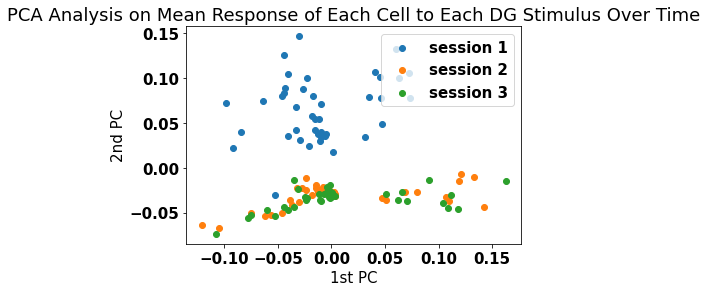

In [282]:
plt.scatter(test_transformed_data1[:,0], test_transformed_data1[:,1], label = "session 1")
plt.scatter(test_transformed_data2[:,0], test_transformed_data2[:,1], label = "session 2")
plt.scatter(test_transformed_data3[:,0], test_transformed_data3[:,1], label = "session 3")
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.title("PCA Analysis on Mean Response of Each Cell to Each DG Stimulus Over Time")
plt.legend(loc="upper right")
plt.show()

In [283]:
# try tsne 
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')

tsne = TSNE(n_components=2) # create PCA model
tsne.fit_transform(concat_mean_matrices) # fit the model with the dataset
test_transformed_data1 = pca.transform(matrices_list1) # fit the model with the dataset
test_transformed_data2 = pca.transform(matrices_list2) # fit the model with the dataset
test_transformed_data3 = pca.transform(matrices_list3) # fit the model with the dataset

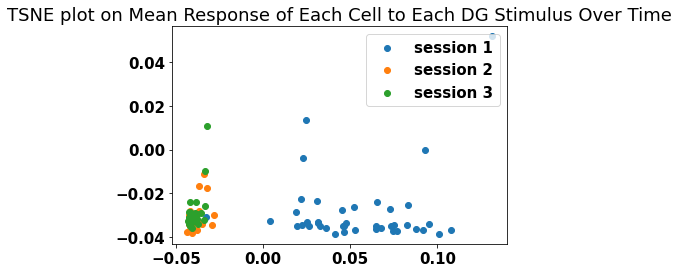

In [285]:
plt.scatter(test_transformed_data1[:,0], test_transformed_data1[:,1], label = "session 1")
plt.scatter(test_transformed_data2[:,0], test_transformed_data2[:,1], label = "session 2")
plt.scatter(test_transformed_data3[:,0], test_transformed_data3[:,1], label = "session 3")
plt.title("TSNE plot on Mean Response of Each Cell to Each DG Stimulus Over Time")
plt.legend(loc="upper right")
plt.show()

In [286]:
test_transformed_data1.shape

(41, 2)

In [411]:
import warnings
warnings.filterwarnings('ignore')

# Performing PCA for each stimulus in a given session. Reshaping matrix so it includes 
# neural responses to all presentations of the stimulus in 2 dimensions, then performing
# PCA 

# New matrix shape is (# neurons, # presentations * 60 frames)

index = 0 
pca_results_dict = {}

pca = PCA(n_components=2) # create PCA model


for stim_id in dg1_responses_by_stimulus.stim_id: # for each stimulus response
    try:
    #print(f"Fitting model for {stim_id}")
        pca = PCA(n_components=2) # create PCA model
        stim_responses = dg1_responses_by_stimulus[dg1_responses_by_stimulus.stim_id == stim_id].response_matrix[index]
        stim_responses = np.reshape(stim_responses, (stim_responses.shape[0],int(stim_responses.shape[1]*4), int(stim_responses.shape[2]/4)))
        summed_responses = np.sum(stim_responses, axis=2).T # sum over 15 frame bins 
        transformed_data = pca.fit_transform(summed_responses) # fit the model with the dataset
        components = pca.components_ # list of principal components (PCs)
        explained_variance_ratio = pca.explained_variance_ratio_ # list of proportion of explained variance for each PC
        pca_results_dict[stim_id] = {"components": components, "explained_variance_ratio": explained_variance_ratio} # add results to dictionary
        index+=1
    except:
        print(f"{stim_id} not reduced by PCA")
        pass
print(summed_responses_test.shape)
    
pca_results = pd.DataFrame(pca_results_dict).T # make a DataFrame
pca_results.head(3) # view PCA results for the first three toy datasets 

(28, 475)


,components,explained_variance_ratio
0.0_1.0_0.0,"[[-0.002396602194116566, -0.001063976954184069...","[0.3267343721405017, 0.17402963189570525]"
0.0_15.0_0.0,"[[2.9471775211629297e-16, -1.4906277133049176e...","[0.5146574988279063, 0.15599813264813328]"
0.0_2.0_0.0,"[[-2.1755105575034183e-17, 0.00835569464080135...","[0.3821655721308132, 0.17114968509909956]"


In [ ]:
for i in range(len(pca_results.index)):
    plt.scatter(pca_results.components[i][0], pca_results.components[i][1])
    plt.scatter(pca_results.components[i][0], pca_results.components[i][1])
    plt.scatter(pca_results.components[i][0], pca_results.components[i][1])
    plt.xlabel("1st PC")
    plt.ylabel("2nd PC")
    plt.title("Drifting Gratings Session 1 PCA Analysis")
    

In [17]:
import warnings
warnings.filterwarnings('ignore')

# Performing PCA for each stimulus in a given session. Reshaping matrix so it includes 
# neural responses to all presentations of the stimulus in 2 dimensions, then performing
# PCA 

# New matrix shape is (# neurons, # presentations * 60 frames)

index = 0 
pca_results_dict = {}

for stim_id in dg1_responses_by_stimulus.stim_id: # for each stimulus response
    try:
        print(f"Fitting model for {stim_id}")
        pca = PCA(n_components=2) # create PCA model
        stim_responses = dg1_responses_by_stimulus[dg1_responses_by_stimulus.stim_id == stim_id].response_matrix[index]
        stim_responses = np.reshape(stim_responses, (stim_responses.shape[0],stim_responses.shape[1]*stim_responses.shape[2]))
        transformed_data = pca.fit_transform(stim_responses) # fit the model with the dataset
        components = pca.components_ # list of principal components (PCs)
        explained_variance_ratio = pca.explained_variance_ratio_ # list of proportion of explained variance for each PC
        pca_results_dict[stim_id] = {"components": components, "explained_variance_ratio": explained_variance_ratio} # add results to dictionary
        index+=1
    except:
        print(f"{stim_id} not reduced by PCA")
        pass

    
pca_results = pd.DataFrame(pca_results_dict).T # make a DataFrame
pca_results.head(3) # view PCA results for the first three toy datasets 

Fitting model for 0.0_1.0_0.0
Fitting model for 0.0_15.0_0.0
Fitting model for 0.0_2.0_0.0
Fitting model for 0.0_4.0_0.0
Fitting model for 0.0_8.0_0.0
Fitting model for 135.0_1.0_0.0
Fitting model for 135.0_15.0_0.0
Fitting model for 135.0_2.0_0.0
Fitting model for 135.0_4.0_0.0
Fitting model for 135.0_8.0_0.0
Fitting model for 180.0_1.0_0.0
Fitting model for 180.0_15.0_0.0
Fitting model for 180.0_2.0_0.0
Fitting model for 180.0_4.0_0.0
Fitting model for 180.0_8.0_0.0
Fitting model for 225.0_1.0_0.0
Fitting model for 225.0_15.0_0.0
Fitting model for 225.0_2.0_0.0
Fitting model for 225.0_4.0_0.0
Fitting model for 225.0_8.0_0.0
Fitting model for 270.0_1.0_0.0
Fitting model for 270.0_15.0_0.0
Fitting model for 270.0_2.0_0.0
Fitting model for 270.0_4.0_0.0
Fitting model for 270.0_8.0_0.0
Fitting model for 315.0_1.0_0.0
Fitting model for 315.0_15.0_0.0
Fitting model for 315.0_2.0_0.0
Fitting model for 315.0_4.0_0.0
Fitting model for 315.0_8.0_0.0
Fitting model for 45.0_1.0_0.0
Fitting model

,components,explained_variance_ratio
0.0_1.0_0.0,"[[0.5185508661287285, -3.4225883358218745e-05,...","[0.21718931152241008, 0.07639376880530951]"
0.0_15.0_0.0,"[[-1.9427010005951442e-19, -1.1102230246251565...","[0.6536357466585896, 0.06381124928094718]"
0.0_2.0_0.0,"[[-1.1116524863467072e-05, 0.00012422785608641...","[0.3812941968542213, 0.06666559446647564]"


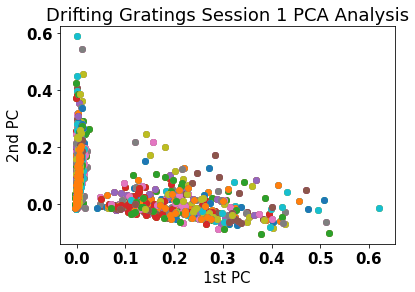

In [21]:
for i in range(len(pca_results.index)):
    plt.scatter(pca_results.components[i][0], pca_results.components[i][1])
    plt.scatter(pca_results.components[i][0], pca_results.components[i][1])
    plt.scatter(pca_results.components[i][0], pca_results.components[i][1])
    plt.xlabel("1st PC")
    plt.ylabel("2nd PC")
    plt.title("Drifting Gratings Session 1 PCA Analysis")
    

In [18]:
import warnings
warnings.filterwarnings('ignore')

# Performing PCA for each stimulus in a given session. Reshaping matrix so it includes 
# neural responses to all presentations of the stimulus in 2 dimensions, then performing
# PCA 

# New matrix shape is (# neurons, # presentations * 60 frames)

index = 0 
pca_results_dict2 = {}

for stim_id in dg2_responses_by_stimulus.stim_id: # for each stimulus response
    try:
        pca = PCA(n_components=2) # create PCA model
        stim_responses = dg2_responses_by_stimulus[dg2_responses_by_stimulus.stim_id == stim_id].response_matrix[index]
        stim_responses = np.reshape(stim_responses, (stim_responses.shape[0],stim_responses.shape[1]*stim_responses.shape[2]))
        transformed_data2 = pca.fit_transform(stim_responses) # fit the model with the dataset
        components2 = pca.components_ # list of principal components (PCs)
        explained_variance_ratio2 = pca.explained_variance_ratio_ # list of proportion of explained variance for each PC
        pca_results_dict2[stim_id] = {"components": components2, "explained_variance_ratio": explained_variance_ratio2} # add results to dictionary
        index+=1
    except:
        print(f"{stim_id} not reduced by PCA")
        pass

    
pca_results2 = pd.DataFrame(pca_results_dict2).T # make a DataFrame
pca_results2.head(3) # view PCA results for the first three toy datasets 

Fitting model for 0.0_1.0_0.0
Fitting model for 0.0_15.0_0.0
Fitting model for 0.0_2.0_0.0
Fitting model for 0.0_4.0_0.0
Fitting model for 0.0_8.0_0.0
Fitting model for 135.0_1.0_0.0
Fitting model for 135.0_15.0_0.0
Fitting model for 135.0_2.0_0.0
Fitting model for 135.0_4.0_0.0
Fitting model for 135.0_8.0_0.0
Fitting model for 180.0_1.0_0.0
Fitting model for 180.0_15.0_0.0
Fitting model for 180.0_2.0_0.0
Fitting model for 180.0_4.0_0.0
Fitting model for 180.0_8.0_0.0
Fitting model for 225.0_1.0_0.0
Fitting model for 225.0_15.0_0.0
Fitting model for 225.0_2.0_0.0
Fitting model for 225.0_4.0_0.0
Fitting model for 225.0_8.0_0.0
Fitting model for 270.0_1.0_0.0
Fitting model for 270.0_15.0_0.0
Fitting model for 270.0_2.0_0.0
Fitting model for 270.0_4.0_0.0
Fitting model for 270.0_8.0_0.0
Fitting model for 315.0_1.0_0.0
Fitting model for 315.0_15.0_0.0
Fitting model for 315.0_2.0_0.0
Fitting model for 315.0_4.0_0.0
Fitting model for 315.0_8.0_0.0
Fitting model for 45.0_1.0_0.0
Fitting model

,components,explained_variance_ratio
0.0_1.0_0.0,"[[-1.6604481999748288e-18, -0.0011166174045950...","[0.07698756203848135, 0.06807058851179999]"
0.0_15.0_0.0,"[[0.004302124652266031, 0.017325377539348794, ...","[0.13599457073522886, 0.08158991159109381]"
0.0_2.0_0.0,"[[-0.0053544200807894935, -0.00110665835853533...","[0.10962092564876241, 0.070850648788593]"


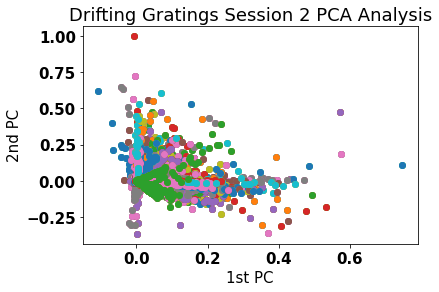

In [22]:
for i in range(len(pca_results2.index)):
    plt.scatter(pca_results2.components[i][0], pca_results2.components[i][1])
    plt.scatter(pca_results2.components[i][0], pca_results2.components[i][1])
    plt.scatter(pca_results2.components[i][0], pca_results2.components[i][1])
    plt.xlabel("1st PC")
    plt.ylabel("2nd PC")
    plt.title("Drifting Gratings Session 2 PCA Analysis")

In [19]:
import warnings
warnings.filterwarnings('ignore')

# Performing PCA for each stimulus in a given session. Reshaping matrix so it includes 
# neural responses to all presentations of the stimulus in 2 dimensions, then performing
# PCA 

# New matrix shape is (# neurons, # presentations * 60 frames)

index = 0 
pca_results_dict3 = {}

for stim_id in dg3_responses_by_stimulus.stim_id: # for each stimulus response
    try:
        #print(f"Fitting model for {stim_id}")
        pca = PCA(n_components=2) # create PCA model
        stim_responses = dg3_responses_by_stimulus[dg3_responses_by_stimulus.stim_id == stim_id].response_matrix[index]
        stim_responses = np.reshape(stim_responses, (stim_responses.shape[0],stim_responses.shape[1]*stim_responses.shape[2]))
        transformed_data3 = pca.fit_transform(stim_responses) # fit the model with the dataset
        components3 = pca.components_ # list of principal components (PCs)
        explained_variance_ratio3 = pca.explained_variance_ratio_ # list of proportion of explained variance for each PC
        pca_results_dict3[stim_id] = {"components": components3, "explained_variance_ratio": explained_variance_ratio3} # add results to dictionary
        index+=1
    except:
        print(f"{stim_id} not reduced by PCA")
        pass

    
pca_results3 = pd.DataFrame(pca_results_dict3).T # make a DataFrame
pca_results3.head(3) # view PCA results for the first three toy datasets 

,components,explained_variance_ratio
0.0_1.0_0.0,"[[0.008214437579652789, -8.326672684688674e-17...","[0.10823531283969681, 0.055538670130975354]"
0.0_15.0_0.0,"[[0.009784517004418491, 5.551115123125783e-17,...","[0.20668814806679148, 0.12296234600680989]"
0.0_2.0_0.0,"[[0.47176798326529623, 0.4017148536680726, 0.1...","[0.10748545568603285, 0.07070045959810532]"


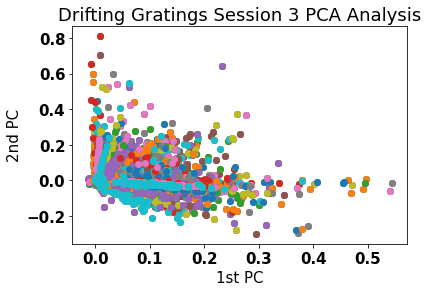

In [23]:
for i in range(len(pca_results3.index)):
    plt.scatter(pca_results3.components[i][0], pca_results3.components[i][1])
    plt.scatter(pca_results3.components[i][0], pca_results3.components[i][1])
    plt.scatter(pca_results3.components[i][0], pca_results3.components[i][1])
    plt.xlabel("1st PC")
    plt.ylabel("2nd PC")
    plt.title("Drifting Gratings Session 3 PCA Analysis")